In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
crypto_currency = 'ETH-USD'

start = dt.datetime(2015, 1, 1)
end = dt.datetime(2023,6,1)
data = yf.download(crypto_currency, start, end)
Bdata = yf.download('BTC-USD', start, end)

#FIO how to make this work. Works without rolling avg. 
data['ETH_7day_MA'] = data['Adj Close'].rolling(window=7).mean()
Bdata['BTC_7day_MA'] = Bdata['Adj Close'].rolling(window=7).mean()

print(data)
print()
print(Bdata)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-11-09   308.644989   329.451996   307.056000   320.884003   320.884003   
2017-11-10   320.670990   324.717987   294.541992   299.252991   299.252991   
2017-11-11   298.585999   319.453003   298.191986   314.681000   314.681000   
2017-11-12   314.690002   319.153015   298.513000   307.907990   307.907990   
2017-11-13   307.024994   328.415009   307.024994   316.716003   316.716003   
...                 ...          ...          ...          ...          ...   
2023-05-27  1828.575684  1836.184570  1817.492065  1831.118286  1831.118286   
2023-05-28  1831.098633  1915.723267  1825.467285  1910.914185  1910.914185   
2023-05-29  1909.297485  1926.421753  1879.077515  1893.078125  1893.078125   
2023-05-30  1893.093140  1916.574951  1883.934692  1901.026611  1901.026611   
2023-05-31  1901.098267  1907.035400  1852.094727  1

In [2]:
price_scaler = MinMaxScaler(feature_range=(0,1))
volume_scaler = MinMaxScaler(feature_range=(0,1))
low_scaler = MinMaxScaler(feature_range = (0,1))
high_scaler = MinMaxScaler(feature_range = (0,1))

Bprice_scaler = MinMaxScaler(feature_range=(0,1))
Bvolume_scaler = MinMaxScaler(feature_range=(0,1))
Blow_scaler = MinMaxScaler(feature_range = (0,1))
Bhigh_scaler = MinMaxScaler(feature_range = (0,1))

# adding seperate scalers for rolling avg but it didnt work. 
#maETH_scaler = MinMaxScaler(feature_range=(0,1))
#maBTC_scaler = MinMaxScaler(feature_range=(0,1))
#scaled_ETH_MA = maETH_scaler.fit_transform(data['ETH_7day_MA'].values.reshape(-1,1))
#scaled_BTC_MA = maBTC_scaler.fit_transform(Bdata['BTC_7day_MA'].values.reshape(-1,1))


scaled_price = price_scaler.fit_transform(data['Close'].values.reshape(-1,1))
scaled_volume = volume_scaler.fit_transform(data['Volume'].values.reshape(-1,1))
scaled_low = low_scaler.fit_transform(data['Low'].values.reshape(-1,1))
scaled_high = high_scaler.fit_transform(data['High'].values.reshape(-1,1))

Bscaled_price = Bprice_scaler.fit_transform(Bdata['Close'].values.reshape(-1,1))
Bscaled_volume = Bvolume_scaler.fit_transform(Bdata['Volume'].values.reshape(-1,1))
Bscaled_low = Blow_scaler.fit_transform(Bdata['Low'].values.reshape(-1,1))
Bscaled_high = Bhigh_scaler.fit_transform(Bdata['High'].values.reshape(-1,1))

prediction_days = 60
x_train, y_train = [], []

for i in range(prediction_days, len(scaled_price)):
    x_train.append(np.column_stack((scaled_price[i-prediction_days:i, 0], scaled_volume[i-prediction_days:i, 0], scaled_low[i-prediction_days:i, 0],scaled_high[i-prediction_days:i, 0]
                    ,Bscaled_price[i-prediction_days:i, 0], Bscaled_volume[i-prediction_days:i, 0], Bscaled_low[i-prediction_days:i, 0], Bscaled_high[i-prediction_days:i, 0])))
    y_train.append(scaled_price[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 8))

Epoch 1/30
56/56 [==============================] - 14s 184ms/step - loss: 0.0139 - val_loss: 0.0042
Epoch 2/30
56/56 [==============================] - 10s 179ms/step - loss: 0.0054 - val_loss: 0.0106
Epoch 3/30
56/56 [==============================] - 10s 182ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 4/30
56/56 [==============================] - 10s 187ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 5/30
56/56 [==============================] - 10s 180ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 6/30
56/56 [==============================] - 10s 182ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 7/30
56/56 [==============================] - 10s 177ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 8/30
56/56 [==============================] - 10s 181ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 9/30
56/56 [==============================] - 10s 182ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 10/30
56/56 [==============================] - 10s 184ms/step - loss: 0.0038 - val_lo

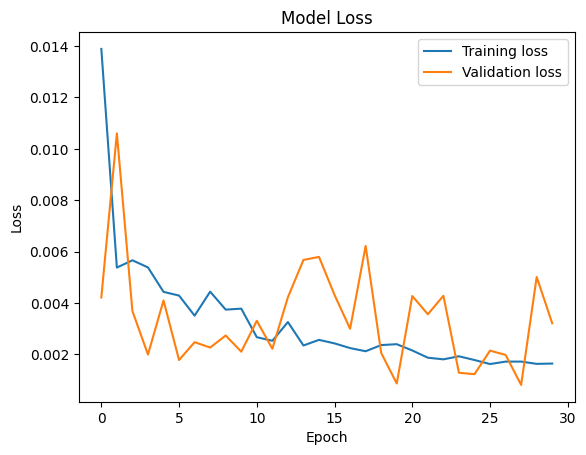

In [3]:
import keras
from keras import layers
model = keras.Sequential()
model.add(layers.LSTM(units = 100, return_sequences = True, input_shape=(x_train.shape[1], 8)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=100, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=100, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=100, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=100, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=100, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))



model.compile(optimizer= 'adam', loss = 'mean_squared_error')



history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)


plt.plot(history.history['loss'], label='Training loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 1/11 [=>............................] - ETA: 0s

11/11 [==============================] - 1s 51ms/step


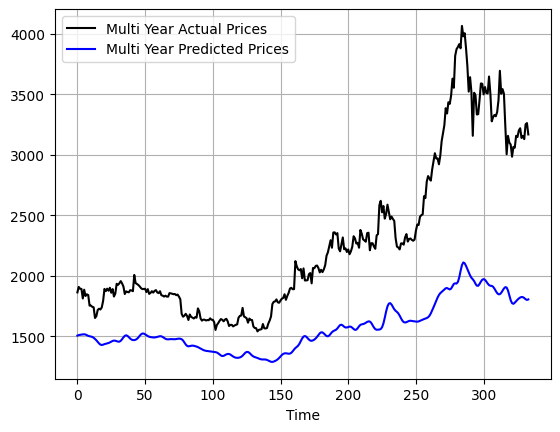

avg distance from actual price [697.7876]
Correct, Wrong and ratio if predicting price is up every day 171 162 0.5135135135135135
overall correct: 162 overall wrong: 171
longest overall correct streak: 6 longest overall wrong streak: 8
explained variance score: 0.4951671298841902
prediction window: 60


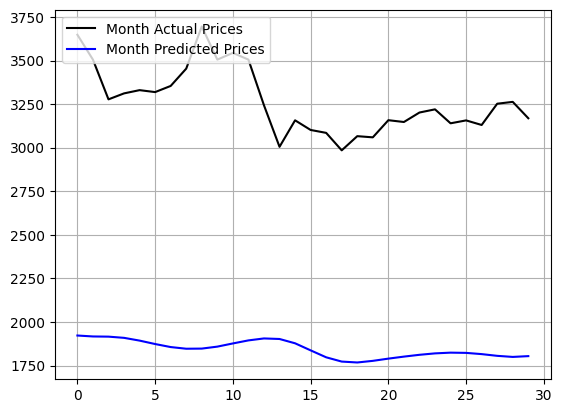

correct: 15 wrong: 14
longest correct streak: 3 longest wrong streak: 3



In [8]:

test_start = dt.datetime(2023,6,1)
test_end = dt.datetime.now()

test_data = yf.download(crypto_currency, test_start, test_end)
Btest_data = yf.download("BTC-USD", test_start, test_end)





actual_prices = test_data['Close'].values

#1
total_price_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
total_volume_dataset = pd.concat((data['Volume'], test_data['Volume']), axis=0)
total_low_dataset = pd.concat((data['Low'], test_data['Low']), axis=0)
total_high_dataset = pd.concat((data['High'], test_data['High']), axis=0)

total_Bprice_dataset = pd.concat((Bdata['Close'], Btest_data['Close']), axis=0)
total_Bvolume_dataset = pd.concat((Bdata['Volume'], Btest_data['Volume']), axis=0)
total_Blow_dataset = pd.concat((Bdata['Low'], Btest_data['Low']), axis=0)
total_Bhigh_dataset = pd.concat((Bdata['High'], Btest_data['High']), axis=0)


#2
model_inputs_price = total_price_dataset[len(total_price_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_volume = total_volume_dataset[len(total_volume_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_low = total_low_dataset[len(total_low_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_high = total_high_dataset[len(total_high_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)

model_inputs_Bprice = total_Bprice_dataset[len(total_Bprice_dataset) - len(Btest_data) - prediction_days:].values.reshape(-1,1)
model_inputs_Bvolume = total_Bvolume_dataset[len(total_Bvolume_dataset) - len(Btest_data) - prediction_days:].values.reshape(-1,1)
model_inputs_Blow = total_Blow_dataset[len(total_Blow_dataset) - len(Btest_data) - prediction_days:].values.reshape(-1,1)
model_inputs_Bhigh = total_Bhigh_dataset[len(total_Bhigh_dataset) - len(Btest_data) - prediction_days:].values.reshape(-1,1)

#3
model_inputs_price = price_scaler.transform(model_inputs_price)  
model_inputs_volume = volume_scaler.transform(model_inputs_volume) 
model_inputs_low = low_scaler.transform(model_inputs_low)  
model_inputs_high = high_scaler.transform(model_inputs_high)

model_inputs_Bprice = Bprice_scaler.transform(model_inputs_Bprice)  
model_inputs_Bvolume = Bvolume_scaler.transform(model_inputs_Bvolume) 
model_inputs_Blow = Blow_scaler.transform(model_inputs_Blow)  
model_inputs_Bhigh = Bhigh_scaler.transform(model_inputs_Bhigh)

#actual_prices = test_data['Close'].values

#model_inputs_price = price_scaler.transform(test_data['Close'].values.reshape(-1,1))
#model_inputs_volume = volume_scaler.transform(test_data['Volume'].values.reshape(-1,1))
#model_inputs_low = low_scaler.transform(test_data['Low'].values.reshape(-1,1))
#model_inputs_high = high_scaler.transform(test_data['High'].values.reshape(-1,1))

#model_inputs_Bprice = Bprice_scaler.transform(test_data['Close'].values.reshape(-1,1))
#model_inputs_Bvolume = Bvolume_scaler.transform(test_data['Volume'].values.reshape(-1,1))
#model_inputs_Blow = Blow_scaler.transform(test_data['Low'].values.reshape(-1,1))
#model_inputs_Bhigh = Bhigh_scaler.transform(test_data['High'].values.reshape(-1,1))

x_test = []

#fix this with rolling averages
for i in range(prediction_days, len(model_inputs_price)):
    x_test.append(np.column_stack((model_inputs_price[i-prediction_days:i, 0],
                                   model_inputs_volume[i-prediction_days:i, 0],
                                   model_inputs_low[i-prediction_days:i, 0],
                                   model_inputs_high[i-prediction_days:i, 0],
                                   model_inputs_Bprice[i-prediction_days:i, 0],
                                   model_inputs_Bvolume[i-prediction_days:i, 0],
                                   model_inputs_Blow[i-prediction_days:i, 0],
                                   model_inputs_Bhigh[i-prediction_days:i, 0]
                                  )))

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 8)) 


prediction_prices = model.predict(x_test)
prediction_prices = price_scaler.inverse_transform(prediction_prices[:, 0].reshape(-1, 1))


prediction_month = prediction_prices[-30:]
actual_month = actual_prices[-30:]

plt.plot(actual_prices, color = 'black', label = 'Multi Year Actual Prices')
plt.plot(prediction_prices, color = 'blue', label = 'Multi Year Predicted Prices')
plt.xlabel('Time')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
up = 0
down = 0
avg = 0
baseline=0
base = []
for i in range(len(prediction_prices)):
    if i != 0:
        base.append(actual_prices[i - 1])
        avg += abs(prediction_prices[i] - actual_prices[i])
        if actual_prices[i] > actual_prices[i- 1]:
            baseline += abs(actual_prices[i-1]-actual_prices[i])
            up += 1
        else:
            down += 1
        if actual_prices[i - 1] > prediction_prices[i] and actual_prices[i - 1] > actual_prices[i]:
            correct += 1
            a = 1
        elif actual_prices[i - 1] < prediction_prices[i] and actual_prices[i - 1] < actual_prices[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
#print("baseline avg distance from actual price", baseline/len(prediction_prices))           
print("avg distance from actual price", avg/len(prediction_prices))        
print("Correct, Wrong and ratio if predicting price is up every day", up, down, up/(down + up))    
print("overall correct:", correct, "overall wrong:", wrong)
print("longest overall correct streak:", longc_streak, "longest overall wrong streak:", longw_streak)
from sklearn.metrics import explained_variance_score
y_true = actual_prices
y_pred = prediction_prices
print("explained variance score:", explained_variance_score(y_true, y_pred))
print("prediction window:", prediction_days)

plt.plot(actual_month, color = 'black', label = 'Month Actual Prices')
plt.plot(prediction_month, color = 'blue', label = 'Month Predicted Prices')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
for i in range(len(prediction_month)):
    if i != 0:
        if actual_month[i - 1] > prediction_month[i] and actual_month[i - 1] > actual_month[i]:
            correct += 1
            a = 1
        elif actual_month[i - 1] < prediction_month[i] and actual_month[i - 1] < actual_month[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
        
    
print("correct:", correct, "wrong:", wrong)
print("longest correct streak:", longc_streak, "longest wrong streak:", longw_streak)
print()

In [5]:
from sklearn.metrics import explained_variance_score
y_true = actual_prices
y_pred = prediction_prices
explained_variance_score(y_true, y_pred)

0.4951946212087467